# Deep Net

Now that we've got all the data, in arrays, and normalized, it's time to train a neural net.

In [13]:
import os
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from IPython.display import display, Markdown, clear_output
from time import time
import tensorflow as tf
import math
%matplotlib inline

## Load preprocessed dataset

In [14]:
with open('data/combined.pickle', 'rb') as f:
    data_dict = pickle.load(f)

X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_test = data_dict['X_test']
y_test = data_dict['y_test']
X_valid = data_dict['X_valid']
y_valid = data_dict['y_valid']

del data_dict # Free all the mallocs!

print("Train shape: %s, %s" % (X_train.shape, y_train.shape))
print("Test shape: %s, %s" % (X_test.shape, y_test.shape))
print("Valid shape: %s, %s" % (X_valid.shape, y_valid.shape))

Train shape: (15000, 100, 100), (15000, 150, 150)
Test shape: (2500, 100, 100), (2500, 150, 150)
Valid shape: (2500, 100, 100), (2500, 150, 150)


## Reformat tensor

Define the size of the patch

In [26]:
patch_size = (10, 10)
patch_size_out = (15, 15) # 1/3rd bigger

## Define a CNN

In [27]:
# hidden parameters
n_hidden_1 = 2048 # 1st layer num features
n_hidden_2 = 1024 # 2nd layer num features
n_input = patch_size[0]*patch_size[1] # data shape
n_output = patch_size_out[0]*patch_size_out[1] # data shape

# parameters
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10

# activation
# activate = tf.nn.sigmoid
# activate = tf.nn.relu
activate = tf.tanh

# This neural net is composed of 2 steps,
# the first it encodes the data, with 1 hidden layer,
# the second does the opposite, converts it back to
# the original shape

def bengio_glorot_init(inputs, outputs):
    return math.sqrt(6) / (math.sqrt(inputs) + math.sqrt(outputs) + 1)
#
std_dev_1 = bengio_glorot_init(n_input, n_hidden_1)
std_dev_2 = bengio_glorot_init(n_hidden_1, n_hidden_2)

# Encode
def encode(x):
    # First layer
    layer_1 = activate(tf.add(tf.matmul(x, W['encoder_h1']), b['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = activate(tf.add(tf.matmul(layer_1, W['encoder_h2']), b['encoder_b2']))
    return layer_2

# Decode
def decode(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = activate(tf.add(tf.matmul(x, W['decoder_h1']), b['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = activate(tf.add(tf.matmul(layer_1, W['decoder_h2']), b['decoder_b2']))
    return layer_2

graph = tf.Graph()
with graph.as_default():

    # input variables
    tf_X = tf.placeholder(tf.float32, shape=(batch_size, n_input))
    tf_y = tf.placeholder(tf.float32, shape=(batch_size, n_output))
    tf_X_valid = tf.constant(X_valid)
    tf_X_test = tf.constant(X_test)

    # weights / slopes
    W = {
        'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev=std_dev_1)),
        'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=std_dev_2)),
        'decoder_h1': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1], stddev=std_dev_2)),
        'decoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_output], stddev=std_dev_1))
    }
    # biases / intercepts
    b = {
        'encoder_b1': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=std_dev_1)),
        'encoder_b2': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=std_dev_2)),
        'decoder_b1': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=std_dev_2)),
        'decoder_b2': tf.Variable(tf.truncated_normal([n_output], stddev=std_dev_1))
    }
    
    # Execute sequence of encoding -> decoding to
    # generate predictions
    y_pred = decode(encode(tf_X))
    
    # Our goal is to reduce the mean between the originals and the predictions.
    # This value is squared to be more aggressive with distant values
    loss = tf.reduce_mean(tf.pow(tf_y - y_pred, 2))
    
    # Learning rate with exponential decay
    global_step = tf.Variable(0, trainable=False) 
    learning_rate = tf.train.exponential_decay(0.01 / n_hidden_1, global_step, 30000, 0.96)
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
#     optimizer = tf.train.AdadeltaOptimizer(0.01 / n_hidden_1).minimize(loss)
    optimizer =  tf.train.RMSPropOptimizer(learning_rate).minimize(loss)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()


In [28]:
# Accuracy is the difference between both images
def difference(predictions, labels):
    return np.mean(np.abs(predictions - labels))
#     diff = predictions - labels
#     return np.sqrt(np.sum(diff ** 2))

Minibatch loss at step 2800: 0.015619
Minibatch diff: 0.079
Validation diff: 0.078


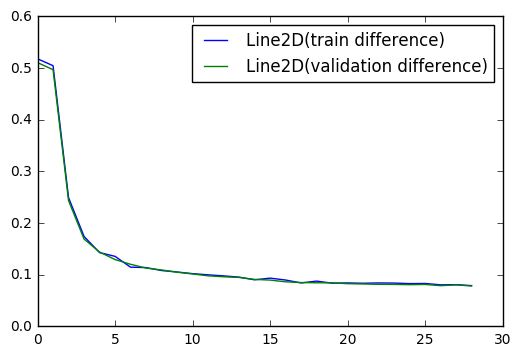

### Train results

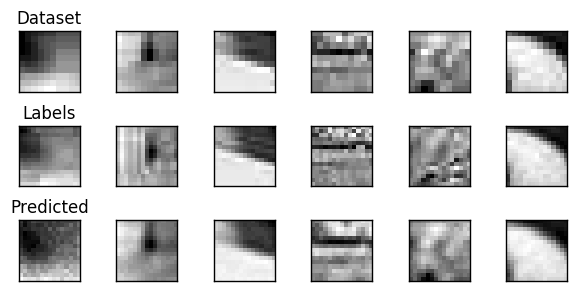

### Test results

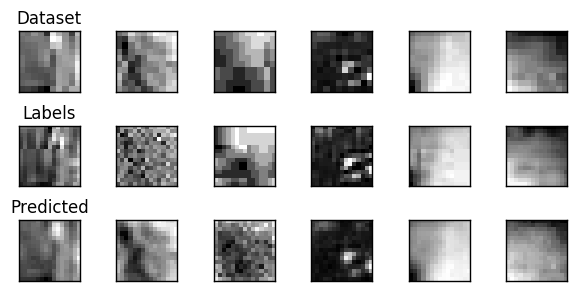

......

KeyboardInterrupt: 

In [29]:
# Set this variable not a valid string to load a model
# or to `None` to start fresh
checkpoint = None

save_step = 10000
preview_step = 100
examples_to_show = 6

keep_training = 200001
row_names = ("Dataset", "Labels", "Predicted")

# Accuracy arrays to draw a chart
train_diff = [];
val_diff = [];

def show_stats():
    """ Print learning curve """
    handle1, = plt.plot(train_diff, label="train difference")
    handle2, = plt.plot(val_diff, label="validation difference")
    plt.legend([handle1, handle2], loc="best")
    plt.show()
    plt.draw()

def show_plot(train, labels, predictions):
    """ Print an image grid """
    # Compare original images with their reconstructions
    f, a = plt.subplots(3, examples_to_show, figsize=(examples_to_show, 3))
    # Hide labels
    for axis in f.axes:
        axis.set_xticks([])
        axis.set_yticks([])
    # Row names
    for axis, row_name in zip(a[:,0], row_names):
        axis.set_title(row_name)

    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(train[i], patch_size), cmap="gray", interpolation="nearest")
        a[1][i].imshow(np.reshape(labels[i], patch_size_out), cmap="gray", interpolation="nearest")
        a[2][i].imshow(np.reshape(predictions[i], patch_size_out), cmap="gray", interpolation="nearest")
    f.tight_layout()
    plt.show()


def get_patches(dataset, labels, batch_start):
    """ Given an X,y array, return image patches """
    batch_data = np.empty((batch_size, patch_size[0]*patch_size[1]))
    batch_labels = np.empty((batch_size, patch_size_out[0]*patch_size_out[1]))
    
    for i in range(batch_size):
        
        # Stochastic optimizer
        x = random.randint(0, dataset.shape[1] - patch_size[0])
        y = random.randint(0, dataset.shape[2] - patch_size[1])
        patch_scale = float(patch_size_out[0])/patch_size[0]
        
        data_w = dataset[batch_start+i, x: x+patch_size[0], y: y+patch_size[1]]
        label_w = labels[
            batch_start+i, 
            int(x*patch_scale) : int(x*patch_scale + patch_size_out[0]),
            int(y*patch_scale) : int(y*patch_scale + patch_size_out[1])
        ]

        batch_data[i] = np.array(data_w).reshape((1, batch_data.shape[1]))
        batch_labels[i] = np.array(label_w).reshape((1, batch_labels.shape[1]))
    return (batch_data, batch_labels)
    
with tf.Session(graph=graph) as session:
    
    # Restore variables from disk.
    if not checkpoint is None:
        saver.restore(session, checkpoint)
    else:
        tf.initialize_all_variables().run()
    
    print('Initialized')
    for step in range(keep_training):
        print(".", end="")
        
        batch_start = random.randint(0, X_train.shape[0] - batch_size - 1)
        batch_data, batch_labels = get_patches(X_train, y_train, batch_start)
            
        # Data passed into the session
        feed_dict = {
            tf_X : batch_data, 
            tf_y : batch_labels,
            global_step: step
        }
        
        # Run session
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # Showing training progress with a chart and images
        if (step % preview_step == 0):
            
            t_total = []
            train_batches = 3 # train n samples of 256 patches. We don't need everything to draw a graph
            for i in range(train_batches):
                offset = random.randint(0, X_train.shape[0] - batch_size)
                train_data, train_labels = get_patches(X_train, y_train, offset)
                train_predictions = session.run(y_pred, feed_dict= {
                    tf_X : train_data
                })
                t_total.append(difference(train_predictions, train_labels))
            t_diff = sum(t_total) / len(t_total)
            train_diff.append(t_diff)
            
            # Validation score
            valid_batches = int(X_valid.shape[0]/batch_size)
            v_total = []
            for i in range(valid_batches):
                offset = i * batch_size
                valid_data, valid_labels = get_patches(X_valid, y_valid, offset)
                valid_predictions = session.run(y_pred, feed_dict= {
                    tf_X : valid_data
                })
                v_total.append(difference(valid_predictions, valid_labels))
            v_diff = sum(v_total) / len(v_total)
            val_diff.append(v_diff)
            
            # Validation images
            random_batch = random.randint(0, valid_batches-1)
            valid_data, valid_labels = get_patches(X_valid, y_valid, random_batch * batch_size)
            valid_predictions = session.run(y_pred, feed_dict= {
                tf_X : valid_data
            })

            clear_output()
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch diff: %.3f" % t_diff)
            print("Validation diff: %.3f" % v_diff)
            
            show_stats()
            
            display(Markdown("### Train results"))
            show_plot(train_data, train_labels, train_predictions)
            
            display(Markdown("### Test results"))
            show_plot(valid_data, valid_labels, valid_predictions)

            
        if (step % save_step == 0):
            save_path = saver.save(session, ("model_global_step_%s_chart_step_%s.ckpt" % (step, len(train_diff))))
            print("Model saved in file: %s" % save_path)
